# Lesson 4: Tool Use and Conversational Chess

## Setup

In [1]:
llm_config = {"model": "gpt-4-turbo"}

In [2]:
import chess
import chess.svg
from typing_extensions import Annotated

## Initialize the chess board

In [3]:
board = chess.Board()

In [4]:
made_move = False

## Define the needed tools

### 1. Tool for getting legal moves

In [5]:
def get_legal_moves(
    
) -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join(
        [str(move) for move in board.legal_moves]
    )

### 2. Tool for making a move on the board

In [6]:
def make_move(
    move: Annotated[str, "A move in UCI format."]
) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    
    # Display the board.
    display(
        chess.svg.board(
            board,
            arrows=[(move.from_square, move.to_square)],
            fill={move.from_square: "gray"},
            size=200
        )
    )
    
    # Get the piece name.
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    return f"Moved {piece_name} ({piece_symbol}) from "\
    f"{chess.SQUARE_NAMES[move.from_square]} to "\
    f"{chess.SQUARE_NAMES[move.to_square]}."

## Create agents

You will create the player agents and a board proxy agents for the chess board.

In [7]:
from autogen import ConversableAgent

In [8]:
# Player white agent
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [9]:
# Player black agent
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [10]:
def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False


In [11]:
board_proxy = ConversableAgent(
    name="Board Proxy",
    llm_config=False,
    is_termination_msg=check_made_move,
    default_auto_reply="Please make a move.",
    human_input_mode="NEVER",
)

## Register the tools

A tool must be registered for the agent that calls the tool and the agent that executes the tool.

In [12]:
from autogen import register_function

In [13]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )
    
    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

In [14]:
player_black.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'Get legal moves.',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}},
 {'type': 'function',
  'function': {'description': 'Call this tool to make a move.',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string',
      'description': 'A move in UCI format.'}},
    'required': ['move']}}}]

## Register the nested chats

Each player agent will have a nested chat with the board proxy agent to
make moves on the chess board.

In [16]:
player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
        }
    ],
)

## Start the Game

The game will start with the first message.

<p style="background-color:#ECECEC; padding:15px; "> <b>Note:</b> In this lesson, you will use GPT 4 for better results. Please note that the lesson has a quota limit. If you want to explore the code in this lesson further, we recommend trying it locally with your own API key.

**Note**: You might get a slightly different moves than what's shown in the video.

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_GFFANyWWtKD3zs7H6q49qTER): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_GFFANyWWtKD3zs7H6q49qTE

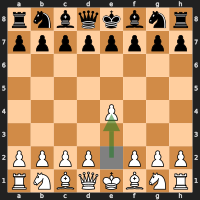

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_RlU8UO3jsiKs5MaNsG3uGApc) *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from e2 to e4. Your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from e2 to e4. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from e2 to e4. Your turn!

-------------------------------------

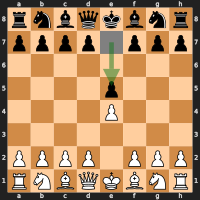

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_7CTmsGtBkl1cAA8lqwbHF1mw) *****
Moved pawn (♟) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from e7 to e5. It's your turn!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from e7 to e5. It's your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my pawn from e7 to e5. It's your turn!

----------------------

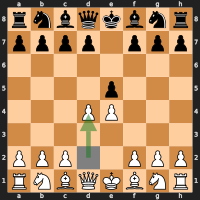

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_9zz5uKLARO8egGxBl29Sf6gu) *****
Moved pawn (♙) from d2 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from d2 to d4. It's your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from d2 to d4. It's your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from d2 to d4. It's your turn!

----------------------

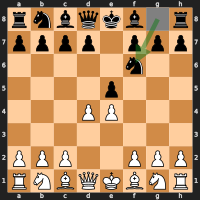

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_QQkv7pi3KSmopw3ZWnmAGBQ8) *****
Moved knight (♞) from g8 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved the knight from g8 to f6. It's your turn!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved the knight from g8 to f6. It's your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved the knight from g8 to f6. It's your turn!

-----------

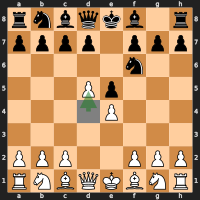

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_ayfLCqqMQtGrBG6qDLlaxaQY) *****
Moved pawn (♙) from d4 to d5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from d4 to d5. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from d4 to d5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from d4 to d5. Your move!

-------------------------------------

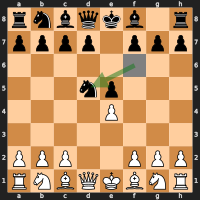

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_GBIdUycuGmRDUWy35iA23ObC) *****
Moved knight (♞) from f6 to d5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved the knight from f6 to d5. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved the knight from f6 to d5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved the knight from f6 to d5. Your move!

--------------------------

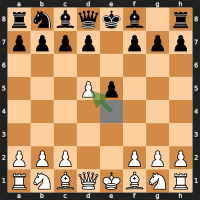

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_5X2zgFZUKNTlxv4V7SzFF8A0) *****
Moved pawn (♙) from e4 to d5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from e4 to d5. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from e4 to d5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from e4 to d5. Your move!

-------------------------------------

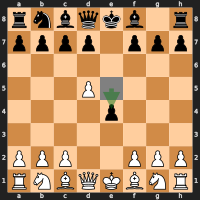

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_oIx9ysnJ0CzLB5ZtalOrxKm1) *****
Moved pawn (♟) from e5 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I have moved my pawn from e5 to e4. It's your turn!

--------------------------------------------------------------------------------
Player Black (to Player White):

I have moved my pawn from e5 to e4. It's your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I have moved my pawn from e5 to e4. It's your turn!

----------------

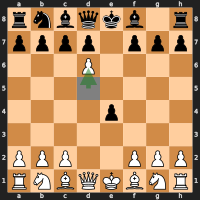

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_55DFQX4ro5pJDhX7iDOd53EW) *****
Moved pawn (♙) from d5 to d6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my pawn from d5 to d6. It's your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my pawn from d5 to d6. It's your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved my pawn from d5 to d6. It's your turn!

-------------------------------

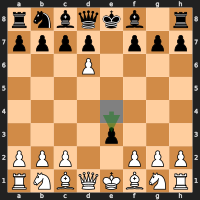

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_yvcvjjC6x3PDlG6hEucP9XJe) *****
Moved pawn (♟) from e4 to e3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from e4 to e3. Your turn!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from e4 to e3. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my pawn from e4 to e3. Your turn!

-------------------------------------

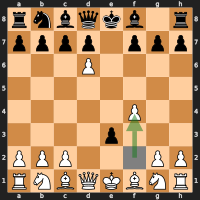

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_4IJRr8YoBdD9xpO8MhGe8UFI) *****
Moved pawn (♙) from f2 to f4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from f2 to f4. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from f2 to f4. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from f2 to f4. Your move!

-------------------------------------

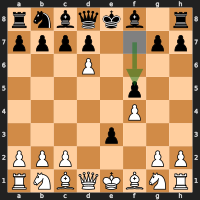

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_fMjretdIcjwISnACflXynvwF) *****
Moved pawn (♟) from f7 to f5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from f7 to f5. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from f7 to f5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my pawn from f7 to f5. Your move!

-------------------------------------

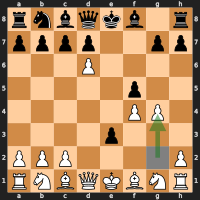

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_pyNuNX662GnqMvCDF8VvuSpI) *****
Moved pawn (♙) from g2 to g4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from g2 to g4. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from g2 to g4. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from g2 to g4. Your move!

-------------------------------------

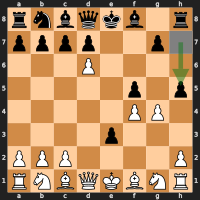

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_zibfVIhKJMnuRCBpOI3ntRIF) *****
Moved pawn (♟) from h7 to h5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from h7 to h5. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from h7 to h5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my pawn from h7 to h5. Your move!

-------------------------------------

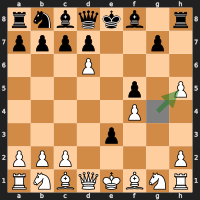

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_IdgoRWopV1Z3meiCOw01lqhP) *****
Moved pawn (♙) from g4 to h5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from g4 to h5. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from g4 to h5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from g4 to h5. Your move!

-------------------------------------

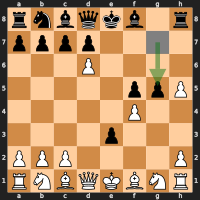

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_XsCdM0tvqDMaqczkAbwkbTso) *****
Moved pawn (♟) from g7 to g5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from g7 to g5. It's your turn now!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from g7 to g5. It's your turn now!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my pawn from g7 to g5. It's your turn now!

----------

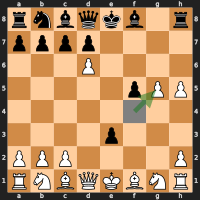

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_9BEpOVl0U0O3EOpEnoqximbA) *****
Moved pawn (♙) from f4 to g5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've captured your pawn on g5 with my pawn from f4. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've captured your pawn on g5 with my pawn from f4. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've captured your pawn on g5 with my pawn from

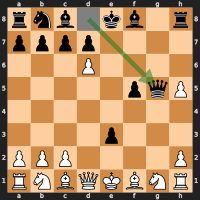

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_a5zHTHRzMivgRAX1drspZDT0) *****
Moved queen (♛) from d8 to g5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my queen from d8 to g5. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my queen from d8 to g5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my queen from d8 to g5. Your move!

---------------------------------

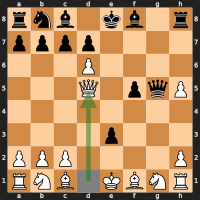

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_auEP7NTkM9WodBGLyWQpFUis) *****
Moved queen (♕) from d1 to d5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my queen from d1 to d5. It's your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my queen from d1 to d5. It's your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my queen from d1 to d5. It's your turn!

------------------

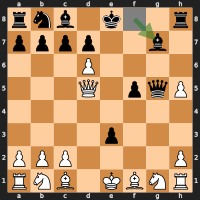

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_pDPSD2TnrXXDyoC2XWH28m6K) *****
Moved bishop (♝) from f8 to g7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my bishop from f8 to g7 to challenge your queen on d5. It's now your turn!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my bishop from f8 to g7 to challenge your queen on d5. It's now your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):


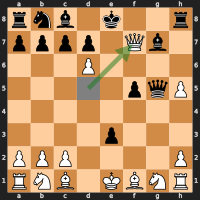

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_nWHnQQGlCGWqKfsBbnmAAfis) *****
Moved queen (♕) from d5 to f7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my queen from d5 to f7, capturing your bishop on g7. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my queen from d5 to f7, capturing your bishop on g7. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved my queen from d5 to 

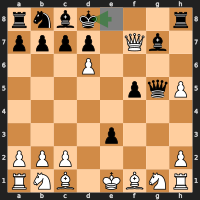

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_osjPh7lJEg7WxSj0QWG3DRqT) *****
Moved king (♚) from e8 to d8.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved my king from e8 to d8. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved my king from e8 to d8. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved my king from e8 to d8. Your move!

----------------------------------------------

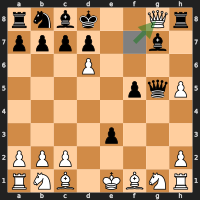

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_YFg7B9PBMjK61nMGaLJzTrmE) *****
Moved queen (♕) from f7 to g8.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my queen from f7 to g8. It's your move now!

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my queen from f7 to g8. It's your move now!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved my queen from f7 to g8. It's your move now!

---------------

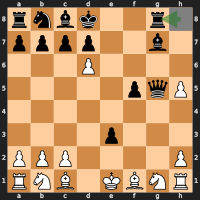

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_VyGUOWVe6lRJyInPySVXS1vi) *****
Moved rook (♜) from h8 to g8.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I captured your queen by moving my rook from h8 to g8. It's your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I captured your queen by moving my rook from h8 to g8. It's your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I captured your queen by moving

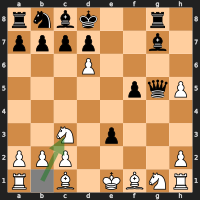

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_YWKwVqT4JHbSxQZi4N4PAhFh) *****
Moved knight (♘) from b1 to c3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my knight from b1 to c3. It's your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my knight from b1 to c3. It's your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my knight from b1 to c3. It's your turn!

--------------

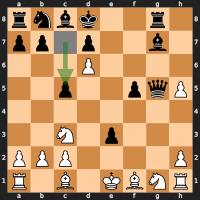

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_mcnWOnZ6yVOKb64iOApm5dGh) *****
Moved pawn (♟) from c7 to c5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved the pawn from c7 to c5. It's your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved the pawn from c7 to c5. It's your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved the pawn from c7 to c5. It's your move!

----------------------------

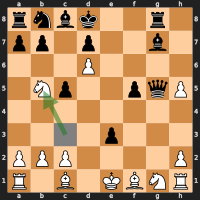

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_z2Fl2Hp5KNGPHJ6cw5UOpQz8) *****
Moved knight (♘) from c3 to b5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved the knight from c3 to b5. It's your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved the knight from c3 to b5. It's your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved the knight from c3 to b5. It's your turn!

-----------

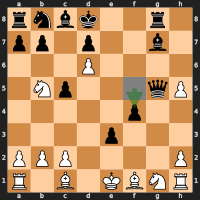

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_TtKRPgKZox6ItKZ6vUO1Hzot) *****
Moved pawn (♟) from f5 to f4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved the pawn from f5 to f4. It's your turn!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved the pawn from f5 to f4. It's your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved the pawn from f5 to f4. It's your turn!

-------------------

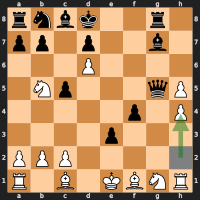

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_2vpSDLpBsfHtTZEy4ysnF8yG) *****
Moved pawn (♙) from h2 to h4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved the pawn from h2 to h4. It's your move now!

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved the pawn from h2 to h4. It's your move now!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved the pawn from h2 to h4. It's your move now!

----------------

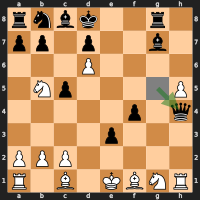

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_rVlhdKEpZh4tuHJjlJ97jw9r) *****
Moved queen (♛) from g5 to h4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my queen from g5 to h4, capturing your pawn. It's your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my queen from g5 to h4, capturing your pawn. It's your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my queen from g5 

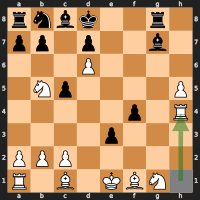

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_tpWdAe8nvY6k6ZLAJ75smp6q) *****
Moved rook (♖) from h1 to h4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my rook from h1 to h4, capturing your queen. It's your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my rook from h1 to h4, capturing your queen. It's your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my rook from h1 to

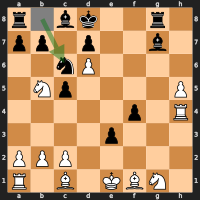

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_HhpK7EjVYd92MXxbFGyMpLEe) *****
Moved knight (♞) from b8 to c6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved the knight from **b8 to c6**. It's your turn now!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved the knight from **b8 to c6**. It's your turn now!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved the knight from **b8 to c6**. It's you

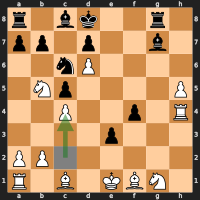

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_oJmIOhG2aJLyy7equQqokFoo) *****
Moved pawn (♙) from c2 to c4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from **c2 to c4**. Now it's your turn.

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from **c2 to c4**. Now it's your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from **c2 to c4**. Now it's your turn.

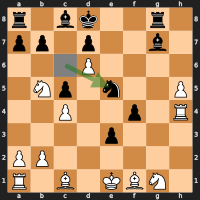

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_ckT98G0cYdn4UT6ZVFaCDhwX) *****
Moved knight (♞) from c6 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved the knight from c6 to e5. Your turn!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved the knight from c6 to e5. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved the knight from c6 to e5. Your turn!

--------------------------

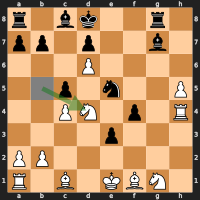

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_zR74uiSbcl4ClEza2kWxOvU2) *****
Moved knight (♘) from b5 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved the knight from b5 to d4. Your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved the knight from b5 to d4. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved the knight from b5 to d4. Your turn!

--------------------------

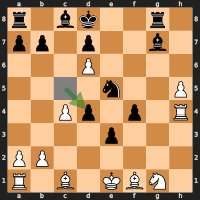

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_MW5RuchOs0yNBPajLezFgwkw) *****
Moved pawn (♟) from c5 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've captured the knight on d4 with the bishop from c5. It's your turn now!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've captured the knight on d4 with the bishop from c5. It's your turn now!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've captured the kni

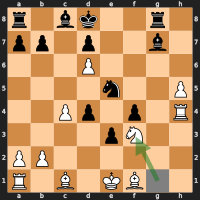

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_AGdhHXlxN2YyKjojLoabK26Q) *****
Moved knight (♘) from g1 to f3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved the knight from g1 to f3. It's your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved the knight from g1 to f3. It's your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved the knight from g1 to f3. It's your turn!

-----------

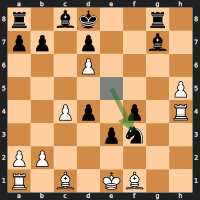

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_lVtCIyxm3cG0t0aQLAwwuSvv) *****
Moved knight (♞) from e5 to f3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved the knight from e5 to f3. Your turn!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved the knight from e5 to f3. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved the knight from e5 to f3. Your turn!

--------------------------

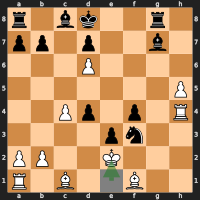

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_zSJ02jz0TplGmfZyfNT3SR0y) *****
Moved king (♔) from e1 to e2.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved the king from e1 to e2. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved the king from e1 to e2. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved the king from e1 to e2. Your move!

----------------------------------

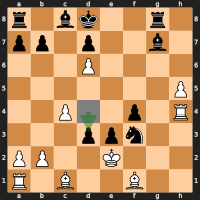

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_c8Wj1LzU1WGgsPXW8amqXnLY) *****
Moved pawn (♟) from d4 to d3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from d4 to d3. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from d4 to d3. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my pawn from d4 to d3. Your move!

-------------------------------------

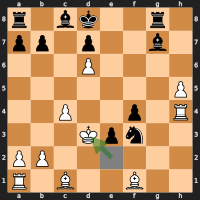

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_OJ8QJPqDijXQM6unyup3OOPW) *****
Moved king (♔) from e2 to d3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my king from e2 to d3. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my king from e2 to d3. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my king from e2 to d3. Your move!

-------------------------------------

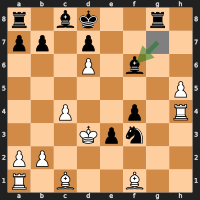

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_5HG0YfGrgjyYjddqCzfspMWR) *****
Moved bishop (♝) from g7 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

The black knight has moved from g7 to f6. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

The black knight has moved from g7 to f6. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

The black knight has moved from g7 to f6. Your move!

-----------

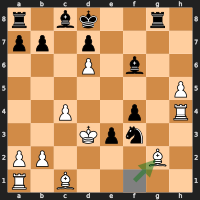

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_nDJyssWnkMZOaW2hJpTQ8IaM) *****
Moved bishop (♗) from f1 to g2.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved the bishop from f1 to g2. Your turn to play as black!

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved the bishop from f1 to g2. Your turn to play as black!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved the bishop from f1 to g2. Your turn to 

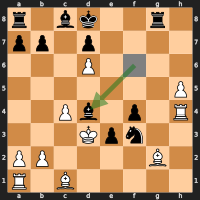

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_CKzq9GWrXs0eg2fqVOzSaA0z) *****
Moved bishop (♝) from f6 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved my knight (♞) from f6 to d4. It's your turn now!

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved my knight (♞) from f6 to d4. It's your turn now!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved my knight (♞) from f6 to d4. It's your turn now!


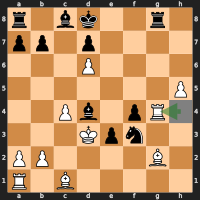

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_0jT2G4KWDRZoY3qdcqw4bJLO) *****
Moved rook (♖) from h4 to g4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my rook from h4 to g4. It's your turn now!

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my rook from h4 to g4. It's your turn now!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved my rook from h4 to g4. It's your turn now!

-------------------

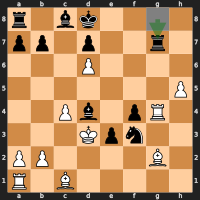

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_D3vlvViANDMvrOF1c9IpkbWb) *****
Moved rook (♜) from g8 to g7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved my rook from g8 to g7. It's your turn now!

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved my rook from g8 to g7. It's your turn now!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved my rook from g8 to g7. It's your turn now!

-------------------

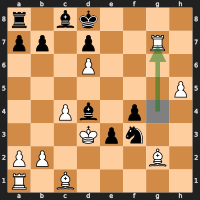

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_2RJrFWKrlgIAOGQtf9VeHbos) *****
Moved rook (♖) from g4 to g7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I have moved my rook from g4 to g7, capturing your rook. It's your move now!

--------------------------------------------------------------------------------
Player White (to Player Black):

I have moved my rook from g4 to g7, capturing your rook. It's your move now!

--------------------------------------------------------------------------------


In [18]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=24,
)

## Adding a fun chitchat to the game!

In [19]:
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [20]:
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [21]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )

    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


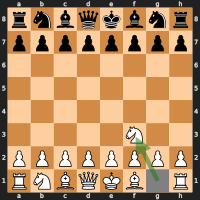


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

The move is done: knight to f3. Your turn! Let's see how you respond to this opening. How's your day been so far, by the way? Anything interesting happening on your end?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


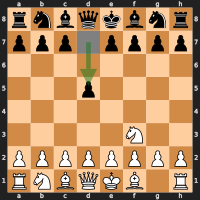


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

The move is done: Pawn to d5. This should lead to some interesting developments in the center!

Your move! What's your strategy going to be in response? And by the way, if you have any favorite chess openings or games, I'd love to hear about them!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


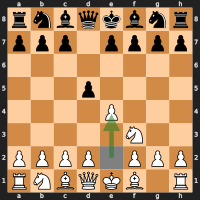


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

Great, I've moved my pawn from e2 to e4, clashing with your pawn in the center. The tension in the center is definitely heating up, which should make for some exciting turns ahead!

How will you respond to this move? And while you think about it, do you have a favorite chess player or a memorable match that really stands out for you?

--------------------------------------------------------------------------------


In [22]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=2,
)

**Note:** 
To add human input to this game, add **human_input_mode="ALWAYS"** for both player agents.